In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


# regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

# Home Assignment 1 - Regression and Classification Models

#### 0.1. Data Preparation

In [2]:
# Load data
df = pd.read_csv("HA1-DatasetScaled.tsv", sep="\t")

In [68]:
# Check data
df.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,52.0
1,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,50.0
2,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,41.5
3,-2.1737,-2.5469,-1.8316,-1.9110,-1.2742,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,0.7124,0.9014,0.8055,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,32.0
4,-2.1737,-1.5994,-0.9850,-1.0041,-0.5006,-3.2043,-2.6712,-2.1218,-1.2523,-2.2206,...,-0.9684,-1.0090,-0.8995,-3.3123,-2.7858,-1.6406,-1.5235,-1.7297,-1.4782,29.0


In [3]:
# Check if any column has a missing value overall (not per row)
print(df.isnull().values.any())

False


#### 0.2: Data Splitting

In [4]:
# DATA SPLITTING #

# Split data into training and validation set
X_train, X_val, y_train, y_val = train_test_split(df.drop('critical_temp', axis=1), df['critical_temp'], test_size=0.2, random_state=42)

# Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

# X_train, y_train: Training data
# X_test, y_test: Test data
# X_val, y_val: Validation data (IVS)

### **Objective 1** - Produce the best regression model for critical_temp (Dependent Variable)

#### 1.1: Decision trees

We will train the model perform GridSearch on testing set to establish the best hyperparameters min_sample_leaf and max_depth:

In [ ]:
# Combine train and test data for GridSearchCV
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

# Create an array of indices:
# -1 indicates the sample is part of the training set
# 0 indicates the sample is part of the test set (used for evaluation during GridSearch)
test_fold = [-1 for _ in range(X_train.shape[0])] + [0 for _ in range(X_test.shape[0])]
ps = PredefinedSplit(test_fold)

# Define the regressor
dtree_regressor = DecisionTreeRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {
    'max_depth': np.arange(2, 7),
    'criterion': ['mse', 'friedman_mse', 'mae'],
    'min_samples_leaf': [5, 10, 20, 25]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(mean_squared_error, greater_is_better=False)

# Run the grid search using the predefined split
gridCV = GridSearchCV(dtree_regressor, parameters, scoring=scorer, cv=ps)

# Fitting the grid search
gridCV.fit(X_combined, y_combined)

# Get the best estimator
dtree_regressor_best = gridCV.best_estimator_

Let's view the results as a table:

In [ ]:
# Extract the results
results = gridCV.cv_results_

# Convert the results to a Pandas dataframe
df_results = pd.DataFrame(results)

# Extract each hyperparameter into its own column from the 'params' column
df_results['max_depth'] = df_results['params'].apply(lambda x: x['max_depth'])
df_results['criterion'] = df_results['params'].apply(lambda x: x['criterion'])
df_results['min_samples_leaf'] = df_results['params'].apply(lambda x: x['min_samples_leaf'])

# Select relevant columns and create the desired dataframe
df_mse = df_results[['max_depth', 'criterion', 'min_samples_leaf', 'mean_test_score']]
df_mse['mean_test_score'] = -df_mse['mean_test_score']  # Convert negative MSE to positive

# Rename columns for clarity
df_mse.columns = ['Max Depth', 'Criterion', 'Min Samples Leaf', 'Mean MSE']

# Drop rows where 'Mean MSE' is NaN
df_mse = df_mse.dropna(subset=['Mean MSE'])

# Display the dataframe by having it as the last statement
df_mse.sort_values(by='Mean MSE')

From the results of the GridSearch the best max_depth is 6 levels and the best min_sample_leaf is 10 samples per leaf. Now let's look at the metrics of the chosen model:

In [ ]:
# Predict on the testing set
y_pred_test = dtree_regressor_best.predict(X_test)

# Calculate metrics
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Print metrics
print(f"Mean Squared Error (MSE) on Testing Set: {mse_test}")
print(f"Root Mean Squared Error (RMSE) on Testing Set: {rmse_test}")
print(f"Mean Absolute Error (MAE) on Testing Set: {mae_test}")
print(f"R-squared on Testing Set: {r2_test}")

Let's test the model on independent validation set (IVS):

In [ ]:
# Predict on the validation set
y_pred_val = dtree_regressor_best.predict(X_val)

# Calculate metrics
mse = mean_squared_error(y_val, y_pred_val)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

# Print metrics
print(f"Mean Squared Error (MSE) on Validation Set: {mse}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"R-squared on Validation Set: {r2}")

#### 1.2: Linear Models

In this section we have tested the following models: Linear Regression, Ridge Regression, Lasso Regression and ElasticNet Regression.

Linear Regression, as implemented by LinearRegression() in scikit-learn, is a simple linear modeling technique where the goal is to find the coefficients (weights) for each feature in the data such that it minimizes the mean squared error (MSE) between the predicted values and the actual target values. The model is trained using the Ordinary Least Squares (OLS) method, which directly computes the optimal weights without any hyperparameters to tune.
Because of this, we will not be able to tune any hyperparameters for Linear Regression. 

However, we can still use regularization to reduce the complexity of the model and prevent overfitting. For that, we will use Ridge, Lasso and ElasticNet Regressions. In addition, for these models, we used cross-validation (or K-Fold Cross Validation) by setting the parameter cv to 5, which meant the data was split into 5 partitions. Other Parameters, such as alpha (regularization strength) and max_iter (maximum number of iterations), were tested and tuned.

In [5]:
# 1. LINEAR REGRESSION MODEL #

# Train model
reg1 = LinearRegression().fit(X_train, y_train)

# Predict on test set
y_pred1_test = reg1.predict(X_test)

In [6]:
# 2. RIDGE REGRESSION MODEL WITH CROSS-VALIDATION (K-Fold Cross Validation) #

# Train model
reg2 = RidgeCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X_train, y_train) # ridge regression with cross-validation and range of alpha values 0.001, 0.01, 0.1, 1

# Predict on test set
y_pred2_test = reg2.predict(X_test)

# Resulting best alpha from cross-validation
reg2_best_alpha = reg2.alpha_ 

In [7]:
# 3. LASSO REGRESSION MODEL WITH CROSS-VALIDATION (K-Fold Cross Validation) #

# Train model
reg3 = LassoCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1], max_iter=10000).fit(X_train, y_train) # lasso regression with cross-validation and range of alpha values 0.001, 0.01, 0.1, 1

# Predict on test set
y_pred3_test = reg3.predict(X_test)

# Resulting best alpha from cross-validation
reg3_best_alpha = reg3.alpha_

C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4168.388300418854, tolerance: 1262.1002303412681
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 391668.0848926394, tolerance: 1262.1002303412681
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11516.109640197828, tolerance: 1261.0921913235463
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\antun\AppData\Roaming\Py

In [8]:
# 4. LASSO REGRESSION MODEL WITH CROSS-VALIDATION (K-Fold Cross Validation) - With Normalised Features #

# Compute statistics from the training set
mean_train = X_train.mean()
max_min_range_train = X_train.max() - X_train.min()

# Normalize the training set
X_train_norm = (X_train - mean_train) / max_min_range_train

# Normalize the test set using the same statistics from the training set
X_test_norm = (X_test - mean_train) / max_min_range_train

# Train model
reg4 = LassoCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1], max_iter=10000).fit(X_train_norm, y_train) # lasso regression with cross-validation and range of alpha values 0.001, 0.01, 0.1, 1

# Predict on test set
y_pred4_test = reg4.predict(X_test_norm)

# Resulting best alpha from cross-validation
reg4_best_alpha = reg4.alpha_

C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1976.777412906289, tolerance: 1259.6342212371567
  model = cd_fast.enet_coordinate_descent_gram(


In [9]:
# 5. ELASTIC NET REGRESSION MODEL WiTH CROSS-VALIDATION (K-Fold Cross Validation) #

# Train model
reg5 = ElasticNetCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1], l1_ratio=[.1, .5, .7, .9, .95, .99, 1], max_iter=10000).fit(X_train, y_train) # elastic net regression with cross-validation and range of alpha values 0.001, 0.01, 0.1, 1 as well as range of l1_ratio values 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1

# Predict on test set
y_pred5_test = reg5.predict(X_test)

# Resulting best alpha from cross-validation
reg5_best_alpha = reg5.alpha_

# Resulting best l1_ratio from cross-validation
reg5_best_l1_ratio = reg5.l1_ratio_

C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4832.20043135155, tolerance: 1262.1002303412681
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1290.6922626583837, tolerance: 1267.9603657561024
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\antun\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2118.835397637449, tolerance: 1257.050542961505
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\antun\AppData\Roaming\Pyth

*NOTE: The warnings above are the result of models not being able to converge. This is due to the fact that several models with different hyperparameters were tested and for some of the parameters the model did not converge. The models that did not converge were not used in the final model selection.*

#### Linear Models: Results

In [12]:
# Create data frame
df_results = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2', 'Best Alpha', 'Best l1_ratio'])

# Create data frames for each model
model1 = pd.DataFrame({'Model': 'Linear Regression', 'MSE': mean_squared_error(y_test, y_pred1_test), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred1_test)), 'MAE': mean_absolute_error(y_test, y_pred1_test), 'R2': r2_score(y_test, y_pred1_test), 'Best Alpha': '-', 'Best l1_ratio': '-'}, index=[0])
model2 = pd.DataFrame({'Model': 'Ridge Regression', 'MSE': mean_squared_error(y_test, y_pred2_test), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred2_test)), 'MAE': mean_absolute_error(y_test, y_pred2_test), 'R2': r2_score(y_test, y_pred2_test), 'Best Alpha': reg2_best_alpha, 'Best l1_ratio': '-'}, index=[1])
model3 = pd.DataFrame({'Model': 'Lasso Regression', 'MSE': mean_squared_error(y_test, y_pred3_test), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred3_test)), 'MAE': mean_absolute_error(y_test, y_pred3_test), 'R2': r2_score(y_test, y_pred3_test), 'Best Alpha': reg3_best_alpha, 'Best l1_ratio': '-'}, index=[2])
model4 = pd.DataFrame({'Model': 'Lasso Regression (Normalised)', 'MSE': mean_squared_error(y_test, y_pred4_test), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred4_test)), 'MAE': mean_absolute_error(y_test, y_pred4_test), 'R2': r2_score(y_test, y_pred4_test), 'Best Alpha': reg4_best_alpha, 'Best l1_ratio': '-'}, index=[3])
model5 = pd.DataFrame({'Model': 'ElasticNet Regression', 'MSE': mean_squared_error(y_test, y_pred5_test), 'RMSE': np.sqrt(mean_squared_error(y_test, y_pred5_test)), 'MAE': mean_absolute_error(y_test, y_pred5_test), 'R2': r2_score(y_test, y_pred5_test), 'Best Alpha': reg5_best_alpha, 'Best l1_ratio': reg5_best_l1_ratio}, index=[4])

# Concatenate the data frames
df_results = pd.concat([df_results, model1, model2, model3, model4, model5], ignore_index=True)

# Print results
df_results



,Model,MSE,RMSE,MAE,R2,Best Alpha,Best l1_ratio
0,Linear Regression,316.112904,17.779564,13.476521,0.732712,-,-
1,Ridge Regression,316.112528,17.779554,13.476474,0.732712,0.01,-
2,Lasso Regression,316.312320,17.785171,13.472501,0.732543,0.001,-
3,Lasso Regression (Normalised),317.339178,17.814016,13.495125,0.731675,0.001,-
4,ElasticNet Regression,316.312320,17.785171,13.472501,0.732543,0.001,1.0


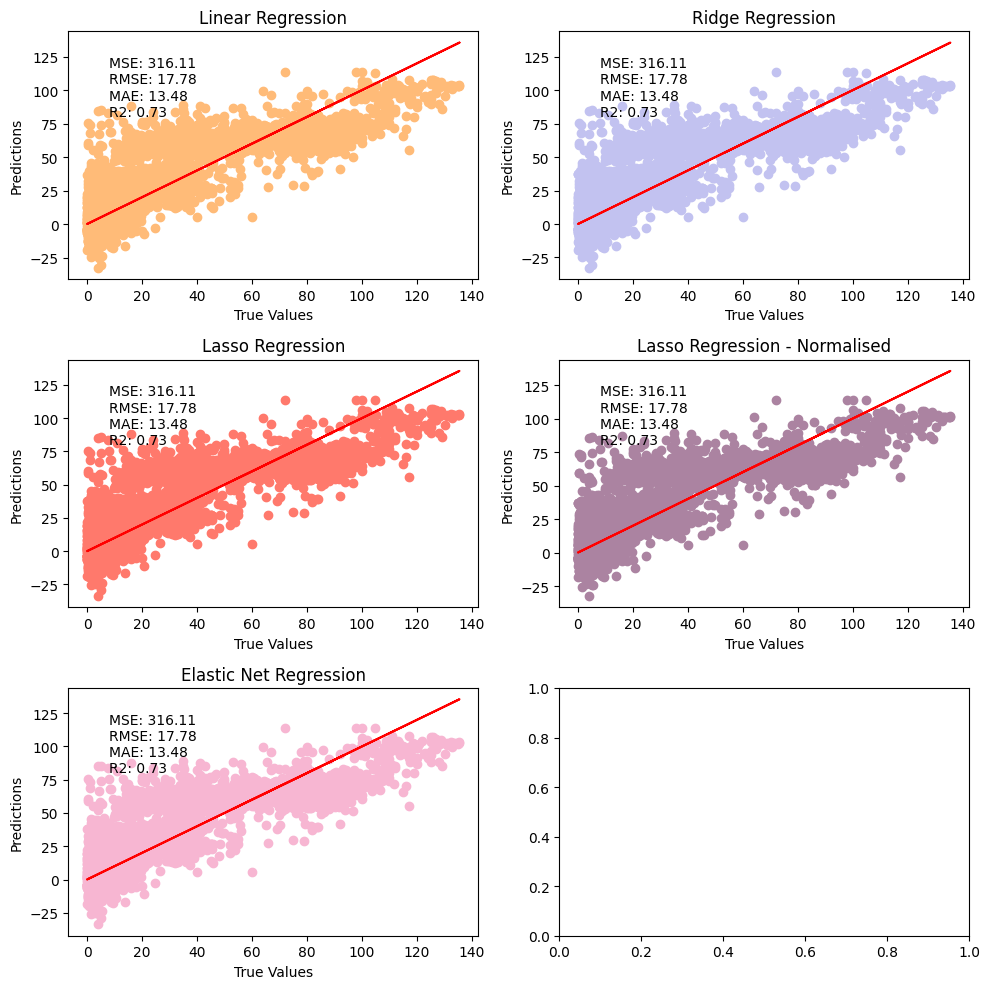

In [15]:
# Plots of the models

# Create figure
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes = axes.flatten()

# List of model names, their predictions, and metrics
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Lasso Regression - Normalised','Elastic Net Regression']
predictions = [y_pred1_test, y_pred2_test, y_pred3_test, y_pred4_test, y_pred5_test]
metrics = [
    f"MSE: {mean_squared_error(y_test, y_pred1_test):.2f}\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred1_test)):.2f}\nMAE: {mean_absolute_error(y_test, y_pred1_test):.2f}\nR2: {r2_score(y_test, y_pred1_test):.2f}"
    for prediction in predictions
]


# Define a list of pastel colors
pastel_colors = ['#FFBB78', '#C2C2F0', '#FF796C', '#AB83A1', '#F7B6D2']

for i, (model_name, prediction, metric, color) in enumerate(zip(models, predictions, metrics, pastel_colors)):
    ax = axes[i]
    ax.scatter(y_test, prediction, color=color)
    ax.plot(y_test, y_test, color='red')
    ax.set_title(model_name)
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predictions')
    ax.text(0.1, 0.9, metric, transform=ax.transAxes, fontsize=10, verticalalignment='top')

# Show plot
plt.tight_layout()
plt.show()

MODEL SELECTION:

All models exhibited similar metrics, which indicated a consistent level of explanatory power. Normalizing features in Lasso Regression slightly reduced performance but without significant advantages. 

Lower alpha in Ridge, Lasso and ElasticNet Regressions resulted in better performance, which makes sense since our data has a large number of features (81) and can be prone to overfitting.

All models performed similarly well, with very similar metrics. In the end we have decided to prioritize simplicity so the final model selected was the Linear Regression. The Linear Regression model's metrics indicate a well-fitting model and we find it to be competitive with the other models as it doesn't introduce any regularization terms. 

#### Validation

In [16]:
# VALIDATION OF THE LINEAR REGRESSION MODEL #   

# Predict on validation set
y_pred1_val = reg1.predict(X_val)

In [18]:
# Calculate metrics for test set
mse_test = mean_squared_error(y_test, y_pred1_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred1_test)
r2_test = r2_score(y_test, y_pred1_test)
  
# Calculate metrics for validation set
mse_val = mean_squared_error(y_val, y_pred1_val)
rmse_val = np.sqrt(mse_val) 
mae_val = mean_absolute_error(y_val, y_pred1_val)
r2_val = r2_score(y_val, y_pred1_val)


# Create a DataFrame to present the metrics
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'MAE', 'RMSE', 'R2'],  # Added RMSE here
    'Test Set': [mse_test, mae_test, rmse_test, r2_test],  # Added RMSE here
    'Validation Set': [mse_val, mae_val, rmse_val, r2_val]  # Added RMSE here
})

# Set the metric column as the index
metrics_df.set_index('Metric', inplace=True)

# Display the DataFrame
metrics_df


,Test Set,Validation Set
Metric,,
MSE,316.112904,318.313848
MAE,13.476521,13.506948
RMSE,17.779564,17.841352
R2,0.732712,0.734041


***CONCUSION:*** The metrics on the validation set are reasonably close to those on the test set which suggests that our model is performing consistently and is likely to generalize well to new, unseen data.

### **Objective 2** - Produce the best binary classification model assuming as positive all instances with values of critical_temp >= 80.0 and as negatives all remaining cases

Firstly, we need to transform all the target columns to the binary classification problem instances.

In [80]:
def transform_to_binary(x):
    return 1 if x >= 80 else 0

y_train_bin = y_train.apply(transform_to_binary)
y_val_bin = y_val.apply(transform_to_binary)
y_test_bin = y_test.apply(transform_to_binary)

In [81]:
y_train_bin.value_counts()

critical_temp
0    11322
1     2229
Name: count, dtype: int64

We can see that the data is imbalanced, we have much more negative (0) observations. Therefore, we will use `F1 score` as our main metric.

#### 2.1 Decision tree

In [82]:
def print_classification_scores(y_true, y_predicted):
    print("The Accuracy is: %7.4f" % accuracy_score(y_true, y_predicted))
    print("The Precision is: %7.4f" % precision_score(y_true, y_predicted))
    print("The Recall is: %7.4f" % recall_score(y_true, y_predicted))
    print("The F1 score is: %7.4f" % f1_score(y_true, y_predicted))
    print("The Confusion Matrix")
    print(pd.DataFrame(confusion_matrix(y_true, y_predicted)))

We will explore different values of the following hyperparameters: `min_samples_leaf`, `max_depth`

In [83]:
min_samples_leaf_values = range(2,50,2)
max_depth_values = range(2,50,2)

results = {"min_samples_leaf": [], "max_depth": [], "F1": []}

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        model.fit(X_train, y_train_bin)
        y_preds = model.predict(X_test)
        f1 = f1_score(y_test_bin, y_preds)

        results["min_samples_leaf"].append(min_samples_leaf)
        results["max_depth"].append(max_depth)
        results["F1"].append(f1)

scores_df = pd.DataFrame(results, index=None)
scores_df = scores_df.sort_values(by="F1", ascending=False)

best_max_depth = int(scores_df.iloc[0].max_depth)
best_min_samples_leaf = int(scores_df.iloc[0].min_samples_leaf)

scores_df

,min_samples_leaf,max_depth,F1
218,6,20,0.792066
530,6,46,0.790953
290,6,26,0.790698
242,6,22,0.790698
555,8,48,0.790634
...,...,...,...
20,42,2,0.473476
21,44,2,0.473476
22,46,2,0.473476
23,48,2,0.473476


We can see that the best combination of hyperparameters is `min_samples_leaf`=6 and `max_depth`=28. When it comes to `min_samples_leaf`, we can be quite sure about this parameter, since all the top 10 best models have it set to 6. However, when it comes to `max_depth`, it varies significantly among the top 10 results and the difference in F1 scores is very small. Therefore, we will explore this parameter a bit deeper.

To make sure our model does not overfit, we will compare the results on the training as well as the validation set.

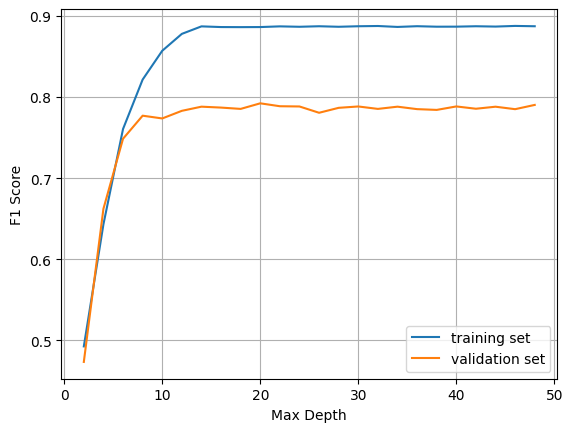

In [84]:
f1_scores_train = []
f1_scores_test = []

for max_depth in max_depth_values:
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=best_min_samples_leaf)
    model.fit(X_train, y_train_bin)
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)
    f1_scores_train.append(f1_score(y_train_bin, y_preds_train))
    f1_scores_test.append(f1_score(y_test_bin, y_preds_test))

plt.plot(max_depth_values, f1_scores_train, label='training set')
plt.plot(max_depth_values, f1_scores_test, label='test set')
plt.xlabel('Max Depth')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

Based on the plot above we can see that the upper bound for the F1 score on the validation set seems to be 0.8. We already get almost the best possible results on the validation set for `max_depth`~14. With increasing the model complexity to bigger max_depth, we don't get any significant improvements. Thus, we can assume that `max_depth`=14 would be enough.

In [93]:
best_max_depth = 14

model = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
model.fit(X_train, y_train_bin)
y_preds_test = model.predict(X_test)
print("Scores on the test set:\n")
print_classification_scores(y_test_bin, y_preds_test)

Scores on the test set:

The Accuracy is:  0.9247
The Precision is:  0.7754
The Recall is:  0.7768
The F1 score is:  0.7761
The Confusion Matrix
      0    1
0  2691  128
1   127  442


Final model

In [94]:
y_preds_val = model.predict(X_val)
print("Final scores on the Independent Validation Set (IVS):\n")
print_classification_scores(y_val_bin, y_preds_val)

Final scores on the Independent Validation Set (IVS):

The Accuracy is:  0.9259
The Precision is:  0.8126
The Recall is:  0.7563
The F1 score is:  0.7834
The Confusion Matrix
      0    1
0  3353  131
1   183  568


#### 2.2. Linear Models

Baseline - default LogisticRegression model

In [86]:
model = LogisticRegression()
model.fit(X_train, y_train_bin)
y_pred = model.predict(X_test)

print_classification_scores(y_test_bin, y_pred)

The Accuracy is:  0.8964
The Precision is:  0.7163
The Recall is:  0.6344
The F1 score is:  0.6729
The Confusion Matrix
      0    1
0  2676  143
1   208  361


C:\Users\karin\.Studia\Sem2\ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [87]:
c_values = [0.001, 0.01, 0.1, 1, 10]
solver_and_penalty = {'lbfgs': ['l2', None], 'liblinear': ['l1', 'l2'], 'newton-cg': ['l2', None],
                      'newton-cholesky': ['l2', None], 'sag': ['l2', None], 'saga': ['l1', 'l2', None]}

results = {"c": [], "solver": [], "penalty": [], "F1_test": [], "F1_train": []}

for c in c_values:
    for solver in solver_and_penalty.keys():
        for penalty in solver_and_penalty[solver]:
            model = LogisticRegression(C=c, solver=solver, penalty=penalty)
            model.fit(X_train, y_train_bin)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            f1_test = f1_score(y_test_bin, y_pred_test)
            f1_train = f1_score(y_train_bin, y_pred_train)

            results['c'].append(c)
            results['solver'].append(solver)
            results['penalty'].append(penalty)
            results['F1_test'].append(f1_test)
            results['F1_train'].append(f1_train)

scores_df = pd.DataFrame(results, index=None)
scores_df = scores_df.sort_values(by="F1_test", ascending=False)

best_c = scores_df.iloc[0].c # any
best_solver = scores_df.iloc[0].solver # newton-cg/newton-cholesky
best_penalty = scores_df.iloc[0].penalty # None

scores_df

C:\Users\karin\.Studia\Sem2\ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\karin\.Studia\Sem2\ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\karin\.Studia\Sem2\ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\karin\.Studia\Sem2\ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWar

,c,solver,penalty,F1_test,F1_train
57,10.000,newton-cg,None,0.702606,0.683337
18,0.010,newton-cg,None,0.702606,0.683337
44,1.000,newton-cg,None,0.702606,0.683337
5,0.001,newton-cg,None,0.702606,0.683337
31,0.100,newton-cg,None,0.702606,0.683337
...,...,...,...,...,...
6,0.001,newton-cholesky,l2,0.394256,0.343718
4,0.001,newton-cg,l2,0.394256,0.343718
0,0.001,lbfgs,l2,0.394256,0.343718
10,0.001,saga,l1,0.000000,0.000000


Final Model

In [95]:
model = LogisticRegression(C=best_c, solver=best_solver, penalty=best_penalty)
model.fit(X_train, y_train_bin)
y_pred = model.predict(X_test)
print("Final scores on the test set:\n")
print_classification_scores(y_test_bin, y_pred)

C:\Users\karin\.Studia\Sem2\ML\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Final scores on the test set:

The Accuracy is:  0.9023
The Precision is:  0.7188
The Recall is:  0.6872
The F1 score is:  0.7026
The Confusion Matrix
      0    1
0  2666  153
1   178  391


In [96]:
print("Final scores on the Independent Validation Set (IVS):\n")
y_val_preds = model.predict(X_val)
print_classification_scores(y_val_bin, y_val_preds)

Final scores on the Independent Validation Set (IVS):

The Accuracy is:  0.8973
The Precision is:  0.7344
The Recall is:  0.6591
The F1 score is:  0.6947
The Confusion Matrix
      0    1
0  3305  179
1   256  495
